# **DSCI 100 Team 11 Project Proposal: A Look at User Knowledge Data and Classification**

## Introduction

Electrical Direct Current (DC) Machines are responsible for altering electromechanical energy and are used in trains, mills, and mines. 

By method of K-nearest neighbours classification (KNN), using a dataset about students' knowledge on the subject of Electrical DC Machines, we will answer the question of how the knowledge level on Electrical DC Machines of a user is classified based on two predictors: PEG, exam performance of the user for goal objects (knowledge on Electrical DC Machines), and LPR, exam performance of the user for related objects (knowledge on subjects related to Electrical DC Machines) with the goal object.

This dataset is an Excel spreadsheet that has been split into a training and testing dataset. There are 5 predictors: STG ( degree of study time for goal object materials), SCG (degree of repetition number of user for goal object materials), STR (degree of study time of user for related objects with goal object), LPR, and PEG, and one response variable, UNS (knowledge level on Electrical DC Machines of the user), which includes 4 different categories: “Very Low”, “Low”, “Middle”, and “High”.

## Preliminary exploratory data analysis

Reading our dataset into R.

In [1]:
# Loading test and training sets into separate dataframes (they are already separated by the dataset authors)


library(tidyverse)
library(readxl)


ukn_train <- read_excel("Data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", # training data
                                   sheet = 2, 
                                   range = "A1:F259")
ukn_test <- read_excel("Data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", # test data
                                  sheet = 3,
                                  range = "A1:F146")
head(ukn_train)
head(ukn_test)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Our data is already mostly tidied: each of the cell values occurs only once, each vector represents one variable, and each row one observation. All numerical vectors are `<dbl>`.

In [2]:
# There are still a few things we can do to tidy our data


ukn_train_scaled <- ukn_train |>
    mutate(UNS = as_factor(UNS)) |>   # Here we convert USN from <chr> to <fct>
    mutate(UNS = fct_recode(UNS, "Very Low" = "very_low")) |>   # Now we standardize UNS class names between testing and training sets
    mutate(STG = scale(STG),   # And finally scale and centre our numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))


ukn_test_scaled <- ukn_test |>
    mutate(UNS = as_factor(UNS)) |>   # We also want to convert UNS to <fct> with our testing data
    mutate(STG = scale(STG),   # As well as centre and scale the test numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))


head(ukn_train_scaled)
head(ukn_test_scaled)

STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.765089,-1.6780077,-1.9029207,-1.7440515,-1.7967053,Very Low
-1.384627,-1.3005822,-1.4963171,-0.7767309,1.7297900,High
-1.479743,-1.3949386,-1.6996189,-0.7364259,-0.5036570,Low
-1.289512,-1.2062258,-1.2930153,0.8757751,-0.6212069,Middle
-1.384627,-1.3005822,-1.5776378,2.2058409,-0.8563066,Low
-1.337070,-0.9703348,-0.2765062,-1.3410013,0.7893912,Middle


STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.5142778,-1.1525157,0.2452099,-0.6155307,-1.4020025,Very Low
-1.2784849,-1.3772532,0.4470002,0.6235230,-1.0884978,Low
-1.1370092,-0.7929358,0.7698645,0.6235230,1.3847057,High
-0.5711065,-0.7030408,0.9716548,0.8786222,1.3847057,High
-0.4767893,-0.6131458,1.8595318,-0.4697597,1.5588750,High
-0.8540579,-0.9727257,1.0523709,0.2590954,-0.5311562,Low


Creating training data summary statistic tables.

In [40]:
# table_1 counts the number of observations in each UNS class
table_1 <- ukn_train_scaled |>
    group_by(UNS) |>
    count() |>
    rename(count = n)
table_1


# table_2 gives us the minimum, maximum and mean of each numerical variable
table_2 <- ukn_train_scaled |>
    summarize(across(where(is.numeric), .fns =
                     list(minimum = min,
                          maximum = max,
                          mean = mean))) |>
    pivot_longer(cols = everything(),
               names_sep = '_',
               names_to = c('.value', 'variable'))
table_2

UNS,count
<fct>,<int>
Very Low,24
High,63
Low,83
Middle,88


variable,STG,SCG,STR,LPR,PEG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
minimum,-1.765089e+00,-1.678008e+00,-1.902921e+00,-1.744052e+00,-1.796705e+00
maximum,2.943117e+00,2.568030e+00,1.959814e+00,2.246146e+00,1.847340e+00
mean,-8.605035e-17,5.559184e-17,7.350975e-17,1.052412e-16,6.393977e-17


Making some scatterplots to determine what variables are most viable as predictors for `UNS`.

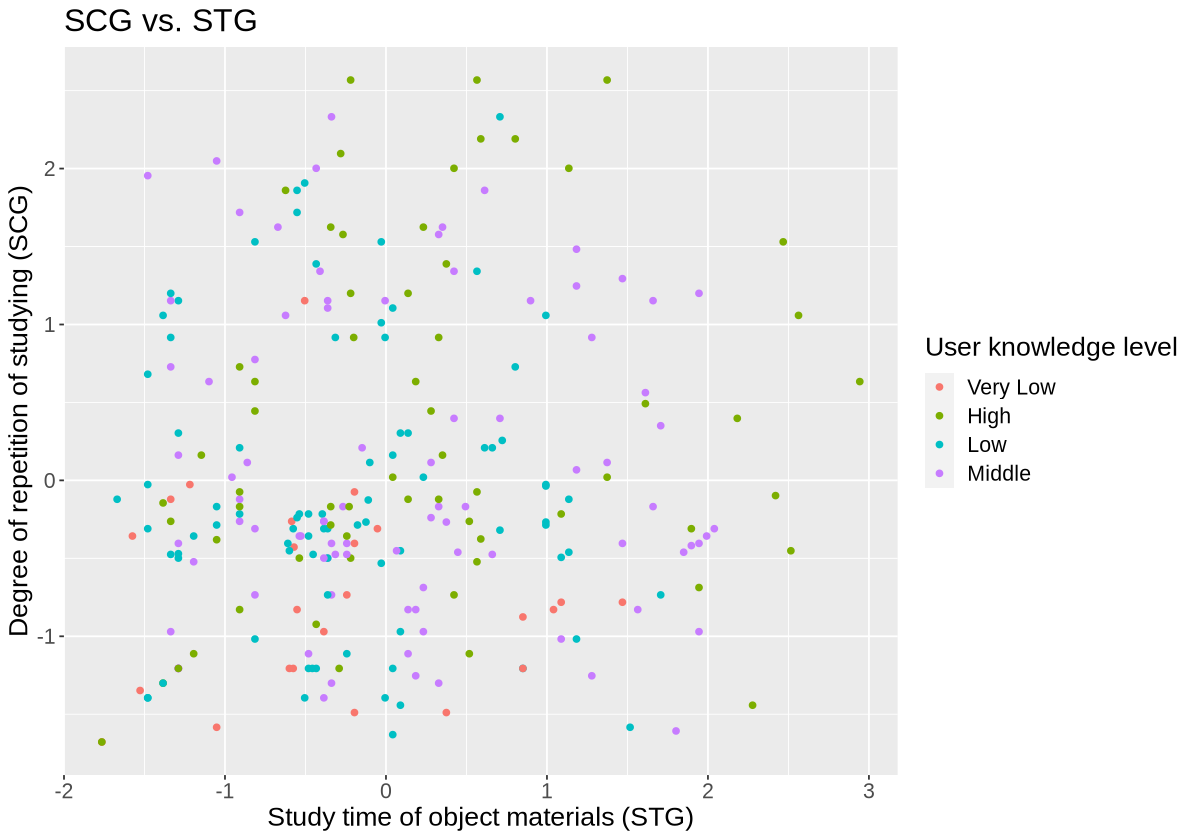

In [52]:
# scatterplot visualizing relationships of SCG, STG and UNS in the scaled training data


options(repr.plot.height = 7, repr.plot.width = 10)


ggplot(ukn_train_scaled,
       aes(x = STG,
           y = SCG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Study time of object materials (STG)',
         y = 'Degree of repetition of studying (SCG)',
         colour = 'User knowledge level',
         title = 'SCG vs. STG') +
    theme(text = element_text(size = 16))

There are no obvious patterns of user knowledge level with either `SCG` or `STG`.Trying different variables:

In [2]:
# scatterplot visualizing relationships of PEG, STR and UNS in the scaled training data


options(repr.plot.height = 7, repr.plot.width = 10)


ggplot(ukn_train_scaled,
       aes(x = STR,
           y = PEG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Study time of materials related to object (STR)',
         y = 'Exam performance for object materials (PEG)',
         colour = 'User knowledge level',
         title = 'PEG vs. STR') +
    theme(text = element_text(size = 16))


ERROR: Error in ggplot(ukn_train_scaled, aes(x = STR, y = PEG, colour = UNS)): could not find function "ggplot"


Here we see a clear positive relationship between `UNS` and `PEG`. However, it doesn't seem to have any relation to `STR`, so it's best if we find a different second predictor.

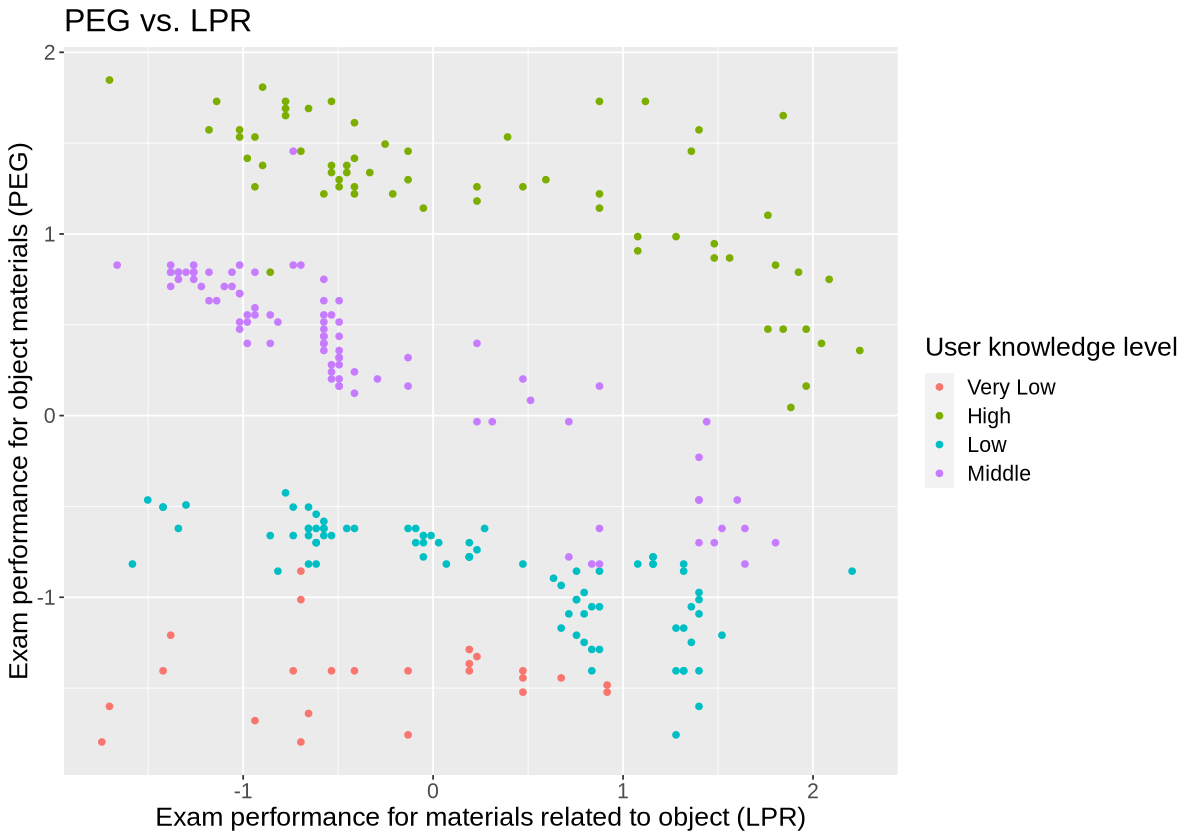

In [54]:
# scatterplot visualizing relationships of PEG, LPR and UNS in the scaled training data


options(repr.plot.height = 7, repr.plot.width = 10)


ggplot(ukn_train_scaled,
       aes(x = LPR,
           y = PEG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Exam performance for materials related to object (LPR)',
         y = 'Exam performance for object materials (PEG)',
         colour = 'User knowledge level',
         title = 'PEG vs. LPR') +
    theme(text = element_text(size = 16))

This scatterplot demonstrates a stronger relationship between both axis variables and user knowledge level. So, we will be able to build a more accurate k-nearest neighbours model using PEG and LPR as predictors. We can now finish tidying our data by selecting only PEG, LPR and USN in both datasets.

In [55]:
ukn_train_scaled <- ukn_train_scaled |>
    select(LPR, PEG, UNS)

ukn_test_scaled <- ukn_test_scaled |>
    select(LPR, PEG, UNS)

head(ukn_train_scaled)
head(ukn_test_scaled)

LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>",<fct>
-1.7440515,-1.7967053,Very Low
-0.7767309,1.7297900,High
-0.7364259,-0.5036570,Low
0.8757751,-0.6212069,Middle
2.2058409,-0.8563066,Low
-1.3410013,0.7893912,Middle


LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>",<fct>
-0.6155307,-1.4020025,Very Low
0.6235230,-1.0884978,Low
0.6235230,1.3847057,High
0.8786222,1.3847057,High
-0.4697597,1.5588750,High
0.2590954,-0.5311562,Low


## Methods

We will classify the UNS as “Very Low”, “Low”, “Middle”, and “High” based on their PEG and LPR. For this classification analysis, we employ the K-nearest neighbours classification algorithm with our 2 predictor variables being PEG and LPR, to predict and classify the categorical variable, UNS.

We can visualize our results through a scatter plot with PEG on the y-axis and LPR on the x-axis. We will add aesthetic mapping by colouring each data point based on their user knowledge level (UNS).

## Expected outcomes and significance

We expect UNS to have a strong, positive, linear relationship between LPR and PEG . The better the performance on the exam, the better will be their overall knowledge of Electrical DC Machines. Analyzing these findings can help to create effective study curricula for electrical DC machines for computer science students. 

Future Questions:
1. To what extent does study time of related subject areas affect the exam performance of our target study area?
2. Does studying related subject areas improve user knowledge of our target study area?

## Bibliography

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.
